In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import (models, transforms)
import os
import utils
from pathlib import Path
import trainer
from torchinfo import summary
import time

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Preparation of the model

We will be using the original ViT in its smallest form (The ViT_B_16) to test the quantization results together with the Imaginette dataset

In [2]:
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights)
pretrained_vit_transforms = pretrained_vit_weights.transforms()

In [3]:
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

pretrained_vit.heads = nn.Linear(in_features=768, out_features=10).to(device)

In [4]:
summary(model=pretrained_vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 10]             768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

We first will do fine-tunning to adecuate the model to the CIFAR10 dataset. Since we just want to test the efficency the quantization achieves and its tradeoff with accuracy, we will train the model for a small number of epochs, since what we want to see is how the accuracy is maintained ¡, and for that we do not need to fit the model perfectly to our data

In [5]:
train_dl, test_dl, val_dl, class_names = utils.create_loaders("data", transform=pretrained_vit_transforms, batch_size=128)

Files already downloaded and verified


In [6]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(pretrained_vit.parameters(), lr=0.03, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=10000)

In [7]:
pretrained_vit_results = trainer.train(model=pretrained_vit, train_dataloader=train_dl, 
                                       test_dataloader=test_dl, optimizer=optimizer, scheduler=scheduler,
                                       loss_fn=loss_fn, epochs=3, device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 0: SGD lr 0.0300 -> 0.0300


 33%|███▎      | 1/3 [06:20<12:41, 380.73s/it]

Epoch: 1 | train_loss: 0.2395 | train_acc: 0.9238 | test_loss: 0.1746 | test_acc: 0.9416
Epoch 1: SGD lr 0.0300 -> 0.0300


 67%|██████▋   | 2/3 [12:52<06:27, 387.47s/it]

Epoch: 2 | train_loss: 0.1404 | train_acc: 0.9536 | test_loss: 0.1702 | test_acc: 0.9452
Epoch 2: SGD lr 0.0300 -> 0.0300


100%|██████████| 3/3 [19:41<00:00, 393.82s/it]

Epoch: 3 | train_loss: 0.1255 | train_acc: 0.9587 | test_loss: 0.1563 | test_acc: 0.9472


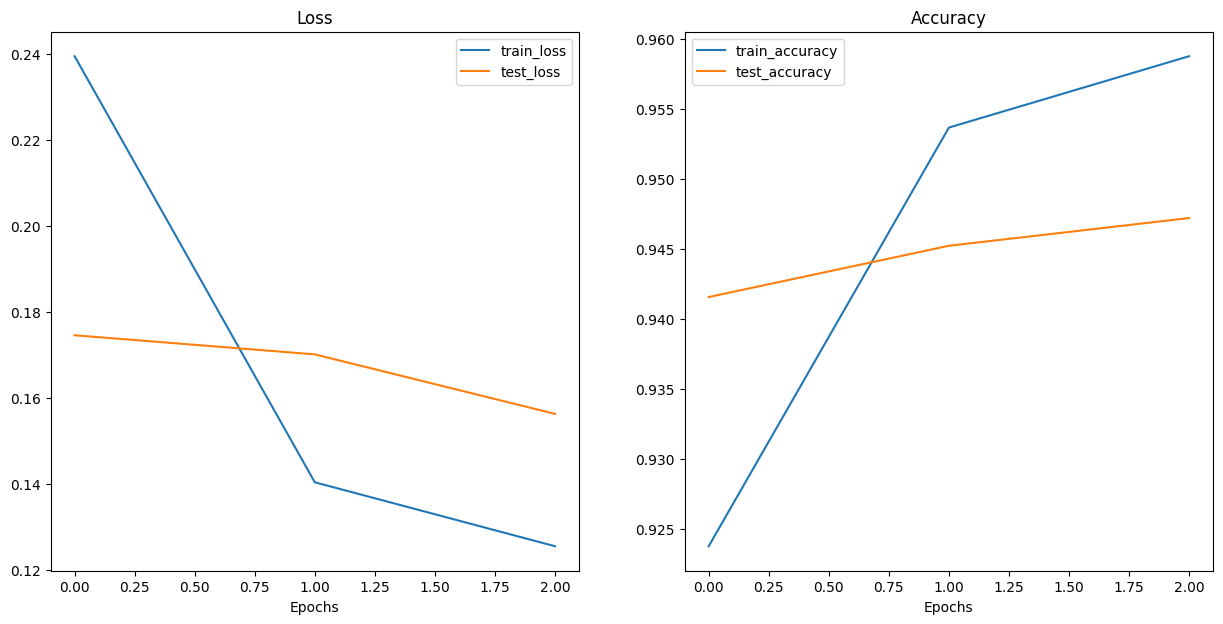

In [8]:
utils.plot_loss_curves(pretrained_vit_results)

After looking at the loss and accuracy curves it seems that our model could benefit from training some additional epochs, but since fitting the model to this particular data is not our goal right now, we will leave it like that

Let's save the model

In [10]:
target_dir_path = Path("model")
target_dir_path.mkdir(parents=True,
                    exist_ok=True)

# Create model save path
model_save_path = target_dir_path / "ViT-Default.pht"

# Save the model state_dict()
print(f"[INFO] Saving model to: {model_save_path}")
torch.save(obj=pretrained_vit.state_dict(),
        f=model_save_path)

[INFO] Saving model to: model\ViT-Default.pht


Now let's see how does it perform on the validation data, how much times does it take to give us the answer and how much does it weight

In [19]:
initial_time = time.time()

results = trainer.evaluate(pretrained_vit, val_dl, loss_fn, device)

elapsed_time = time.time() - initial_time

pretrained_vit_model_size = Path(model_save_path).stat().st_size // (1024*1024)

print(f'Validation loss: {results[0]}\n'
      f'Validation accuracy: {results[1]}\n'
      f'Time elapsed: {elapsed_time}\n'
      f'Number of images: {128*len(val_dl)}\n'
      f'Size (in MB): {pretrained_vit_model_size}')

Validation loss: 0.15731630238551128
Validation accuracy: 0.9491693037974683
Time elapsed: 93.50380873680115
Number of images: 10112
Size (in MB): 327


In [18]:
%timeit -r 20 -n 1 trainer.evaluate(pretrained_vit, val_dl, loss_fn, device)

1min 32s ± 1.47 s per loop (mean ± std. dev. of 20 runs, 1 loop each)
